
### Counterparty Credit Risk (CCR) Modeling

Counterparty Credit Risk (CCR) modeling is a crucial component of risk management, particularly in the realm of derivatives and other financial contracts. The default of one party can lead to substantial losses for the other, making effective CCR management essential.

In this notebook, I will illustrate how to calculate the Expected Positive Exposure (EPE) while considering Credit Valuation Adjustment (CVA), netting, and collateral.

#### Key Concepts: Counterparty Risk, Netting Agreements, and Collateral

These elements significantly influence the exposure and risk profile of derivative transactions:

- **Counterparty Risk**: This refers to the Credit Valuation Adjustment (CVA), which accounts for the risk of counterparty default. CVA is a risk management tool that quantifies this risk in the pricing of derivatives. It represents the difference between the risk-free value of a derivative and its actual value, factoring in the potential for counterparty default.

- **Netting**: This involves consolidating multiple contracts with the same counterparty to reduce overall exposure. By offsetting positive and negative exposures, netting agreements can effectively lower risk.

- **Collateralization**: This process mitigates risk by requiring the counterparty to post collateral against their obligations, thereby reducing potential exposure.

By understanding and applying these concepts, we can better manage counterparty credit risk in derivative transactions.



### Simulating the Pricing of a European Call Option

In this section, I will illustrate how to simulate the pricing of a European call option while accounting for various financial risk factors, including Credit Valuation Adjustment (CVA), netting, and collateral. The simulation follows these steps:

1. **Simulate Price Paths**: The code generates price paths for the underlying asset using Geometric Brownian Motion (GBM).

2. **Calculate Payoff**: At maturity, the payoff of the European call option is calculated based on the simulated price paths.

3. **Credit Valuation Adjustment (CVA)**: 
   - Apply a **default probability** to the exposure to simulate counterparty risk. For instance, if there is a 2% chance of counterparty default, the exposure is adjusted accordingly.

4. **Netting**: 
   - Assume a portfolio of contracts (in this case, 5 contracts). The **positive exposures** from these contracts are netted, meaning that positive payoffs are summed while negative exposures are disregarded.

5. **Collateralization**: 
   - If the exposure exceeds a specified **collateral threshold** (e.g., 5 units), the collateral is used to reduce the exposure. This is modeled by subtracting the collateral threshold from the exposure, ensuring that the exposure does not fall below zero.

6. **Discounting and Expected Positive Exposure (EPE)**: 
   - The adjusted exposure (after accounting for CVA, netting, and collateral) is discounted back to present value using the **risk-free rate**. The **Expected Positive Exposure (EPE)** is then calculated as the average of the discounted exposures over time, reflecting the impact of counterparty risk, netting, and collateral on the overall exposure.



Expected Positive Exposure (EPE) after CVA, Netting, and Collateral: 26.71
   Time  Discounted Adjusted Exposure
0  0.00                      0.000000
1  0.02                      0.726891
2  0.04                      3.215369
3  0.06                      5.114467
4  0.08                      6.726597


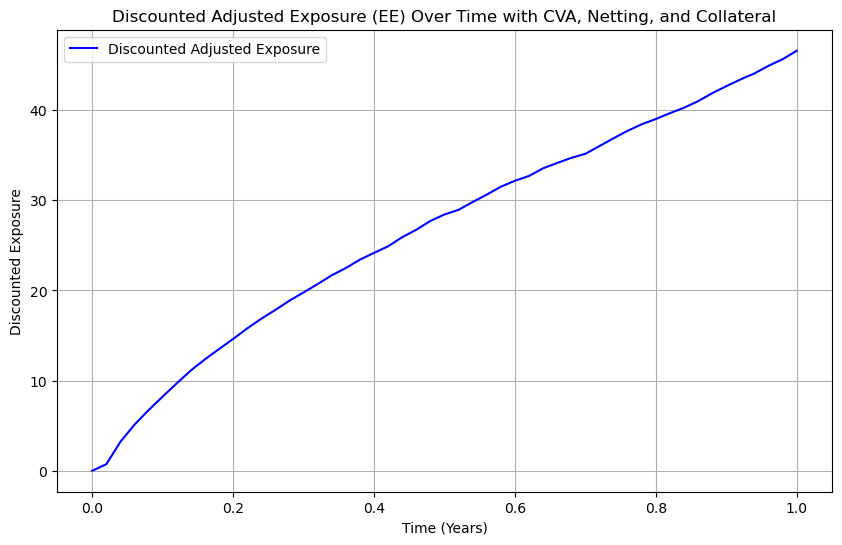

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
num_simulations = 10000
time_horizon = 1  # in years
initial_value = 100  # Initial underlying asset price
volatility = 0.2  # Volatility of the underlying asset
risk_free_rate = 0.05  # Risk-free interest rate
strike_price = 100  # Strike price of the European call option
num_steps = 50  # Number of time steps
num_contracts = 5  # Number of contracts in the portfolio
cva_default_probability = 0.02  # Annual default probability for counterparty
collateral_threshold = 5  # Collateral threshold in option value

# Function to simulate asset paths using GBM
def simulate_asset_paths(S0, T, mu, sigma, steps, n_paths):
    dt = T / steps #time increment-the length of each time step
    Z = np.random.normal(size=(steps, n_paths)) # 2D array of random values for each time step and each simulated path
    S = np.zeros((steps + 1, n_paths)) #2D array initialized to store the simulated asset prices
    S[0] = S0
    for t in range(1, steps + 1): #for each time step t the asset price S[t] is calculated 
        S[t] = S[t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t - 1])
    return S

# Function to calculate the European call option value (payoff) at each time step
def calculate_option_payoff(S, K):
    # European call option payoff: max(S(T) - K, 0)
    return np.maximum(S - K, 0)

# Function to adjust the exposure to account for the counterparty's default risk 
def apply_cva(exposure, default_probability):
    # Adjust exposure by scaling it down based on the default probability
    return exposure * (1 - default_probability)

# Function to apply netting across multiple contracts
def apply_netting(exposures):
    #reduce exposure by summing only the positive exposures across multiple contracts, effectively netting out negative exposures
    return np.sum(np.maximum(exposures, 0), axis=0)

# Function to apply collateral (initial margin) to reduce exposure
def apply_collateral(exposure, collateral_threshold):
    # reduces the exposure by the collateral amount if it exceeds a specified threshold.
    return np.maximum(exposure - collateral_threshold, 0)

# Run the simulation
paths = simulate_asset_paths(initial_value, time_horizon, risk_free_rate, volatility, num_steps, num_simulations)

# Calculate the option payoff at each time step for all contracts in the portfolio
option_payoffs = np.array([calculate_option_payoff(paths, strike_price) for _ in range(num_contracts)])

# Calculate the exposure for each contract (positive payoff)
exposures = np.array([np.mean(option_payoff, axis=1) for option_payoff in option_payoffs])

# Apply netting to the portfolio of contracts
netted_exposure = apply_netting(exposures)

# Apply collateral adjustment
collateralized_exposure = apply_collateral(netted_exposure, collateral_threshold)

# Apply CVA to account for counterparty default risk
adjusted_exposure = apply_cva(collateralized_exposure, cva_default_probability)


# Discount the adjusted exposure to present value
time_grid = np.linspace(0, time_horizon, num_steps + 1)
discount_factors = np.exp(-risk_free_rate * time_grid)
discounted_adjusted_exposure = adjusted_exposure * discount_factors


# Calculate Expected Positive Exposure (EPE) as the average of all discounted adjusted exposures
EPE = np.mean(discounted_adjusted_exposure)

# Create a DataFrame for time and discounted adjusted exposure
exposure_df = pd.DataFrame({'Time': time_grid, 'Discounted Adjusted Exposure': discounted_adjusted_exposure})

# Display summary
print(f"Expected Positive Exposure (EPE) after CVA, Netting, and Collateral: {EPE:.2f}")
print(exposure_df.head())

# Plot the discounted adjusted exposure over time
plt.figure(figsize=(10, 6))
plt.plot(time_grid, discounted_adjusted_exposure, label='Discounted Adjusted Exposure', color='blue')
plt.title('Discounted Adjusted Exposure (EE) Over Time with CVA, Netting, and Collateral')
plt.xlabel('Time (Years)')
plt.ylabel('Discounted Exposure')
plt.grid()
plt.legend()
plt.show()


### Interpretation of Results

 **Expected Positive Exposure (EPE)**: The EPE is calculated to be **26.71**. This value represents the average exposure that the institution can expect to have over the specified time horizon, after considering the effects of counterparty risk (CVA), netting of exposures, and the impact of collateral. A higher EPE indicates a greater potential risk of loss due to counterparty default.

 **Discounted Adjusted Exposure Over Time**:

The trend suggests that the underlying asset's price movements are becoming more favorable, leading to higher potential payoffs.At time 4 (0.08), the exposure reaches **6.726597**. This continued increase indicates that the risk profile remains elevated as time progresses, reflecting ongoing favorable conditions for the option.

### Summary

Overall, the results indicate a growing exposure over time, which is typical in the context of options as they approach maturity. The EPE of **26.71** suggests that, on average, the institution can expect to face a significant level of exposure after accounting for the mitigating effects of CVA, netting, and collateral. This analysis highlights the importance of managing counterparty risk effectively, as the potential for loss increases as the option nears its expiration. 


### Next Steps

**Scenario Analysis**: 
   - Conduct scenario analysis by varying the **default probability** and **collateral threshold**. This will help you understand how changes in these parameters impact the Expected Positive Exposure (EPE) and overall risk profile. For instance, increasing the default probability may lead to a higher CVA, thereby increasing the EPE, while adjusting the collateral threshold can either mitigate or exacerbate exposure depending on the market conditions.

 **Stress Testing**: 
   - Implement stress testing by running simulations under extreme market conditions, such as high volatility or significant asset price movements. This will allow you to assess the robustness of your model and understand how it performs under adverse scenarios. Stress testing can reveal vulnerabilities in your risk management framework and help you prepare for potential market shocks.

 **Multivariate Portfolio**: 
   - Extend the model to accommodate a more complex portfolio that includes multiple asset classes and different types of derivatives. This will provide a more comprehensive view of the overall risk exposure and allow for better risk management strategies. By incorporating correlations between asset classes and the unique characteristics of various derivatives, you can enhance the accuracy of your exposure calculations.
